In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.geodesic import Geodesic
land_color = [85/255, 92/255, 105/255]
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=land_color)
plt.rcParams['axes.grid'] = True
import numpy as np
import xarray as xr
import pandas as pd
import gsw, os
etopo = xr.open_dataset('/home1/datawork/kbalem/ETOPO1_Bed_g_gmt4.nc')
gebco = xr.open_dataset('/home1/datawork/kbalem/GEBCO_2019.nc')

In [2]:
df1 = xr.open_dataset('grd_descent_to_profiles_cln.nc')
df2 = xr.open_dataset('grd_descent_to_parking_cln.nc')

In [24]:
df2

<xarray.Dataset>
Dimensions:          (N_PROF: 2862)
Dimensions without coordinates: N_PROF
Data variables: (12/14)
    LATITUDE         (N_PROF) float64 ...
    LONGITUDE        (N_PROF) float64 ...
    PROFILER_TYPE    (N_PROF) int64 ...
    WMO              (N_PROF) float64 ...
    GROUNDING_DEPTH  (N_PROF) float64 ...
    PROFILE_DEPTH    (N_PROF) float64 ...
    ...               ...
    DEPTH_WARNING    (N_PROF) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    DATE_WARNING     (N_PROF) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    SHALLOW_WARNING  (N_PROF) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    etopo            (N_PROF) float64 745.0 176.5 239.0 ... 3.751e+03 316.3
    gebco            (N_PROF) float64 502.4 181.4 257.2 ... 3.808e+03 258.4
    BATHY_WARNING    (N_PROF) bool False False True True ... False False False

## Interpolate etopo to grounding points

In [4]:
for df in [df1,df2]:
    # SPREAD BATHY : Array of random points around position to interpolate bathy
    # INIT at 100m around points
    PTS=np.array([np.asarray(Geodesic().circle(lon=df['LONGITUDE'].isel(N_PROF=i).values,
                                               lat=df['LATITUDE'].isel(N_PROF=i).values,
                                               radius=100.,
                                               n_samples=25)) for i in range(len(df['N_PROF']))])
    # SPREAD 200-2000m around points
    radius = 2000.0 #in meters
    radrange  = np.linspace(200,radius,10)
    for r in radrange:
        PT0=np.array([np.asarray(Geodesic().circle(lon=df['LONGITUDE'].isel(N_PROF=i).values,
                                                   lat=df['LATITUDE'].isel(N_PROF=i).values,
                                                   radius=r,
                                                   n_samples=50)) for i in range(len(df['N_PROF']))])
        PTS = np.column_stack((PTS,PT0))

    x=xr.DataArray(PTS[:,:,0],dims=['N_PROF','PTS'])
    y=xr.DataArray(PTS[:,:,1],dims=['N_PROF','PTS'])
    spread_bathy = xr.Dataset()
    spread_bathy['etopo'] = -1*etopo.interp(x=x,y=y,method='linear')['z']
    spread_bathy['gebco'] = -1*gebco.interp(lon=x,lat=y,method='linear')['elevation']
    df['etopo'] = spread_bathy['etopo'].mean('PTS')
    df['gebco'] = spread_bathy['gebco'].mean('PTS')

## Groundings map

In [15]:
def make_map(dsl):
    fig=plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
    ax.add_feature(land_feature, edgecolor=None)
    l=0
    for ds in dsl:
        ax.plot(ds['LONGITUDE'],ds['LATITUDE'],'r.', markersize=4, markeredgecolor='None', alpha=1, transform=ccrs.PlateCarree())
        l += len(ds.N_PROF)
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER  
    ax.set_title(str(l)+' profiles')

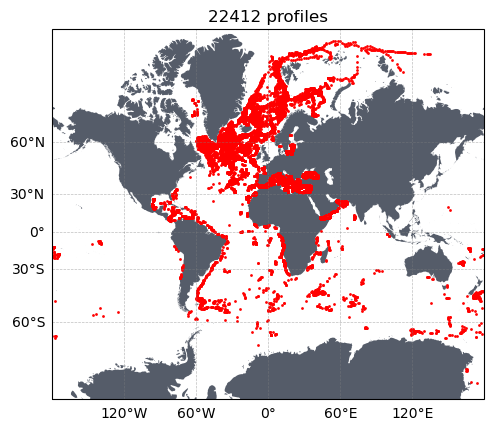

In [17]:
make_map([df1.where((df1['DEPTH_WARNING']==0)&(df1['DATE_WARNING']==0)&(df1['SHALLOW_WARNING']==0),drop=True)])

## Distribution of grounding depths

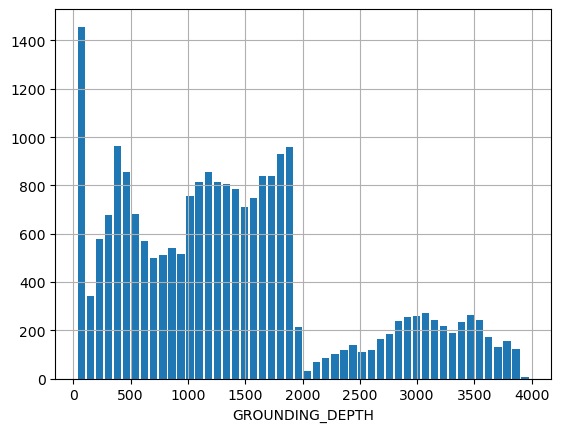

In [18]:
_= df1['GROUNDING_DEPTH'].plot.hist(bins=50,rwidth=0.8)

## Distribution of (Grounding depth - bathy)

In [ ]:
dft = df1.where(df1['PROFILER_TYPE']==838,drop=True)

fig,ax = plt.subplots(1,2,figsize=(15,4))
_=(dft['GROUNDING_DEPTH']-dft['etopo']).plot.hist(bins=50,rwidth=0.8,ax=ax[0])
ax[0].set_yscale('log')
_=(dft['GROUNDING_DEPTH']-dft['gebco']).plot.hist(bins=50,rwidth=0.8,ax=ax[1])
ax[1].set_yscale('log')

In [ ]:
_=(df1['etopo']-df1['gebco']).plot.hist(bins=50,rwidth=0.8)
plt.gca().set_yscale('log')

In [ ]:
make_map([df2.where(np.abs(df2['GROUNDING_DEPTH']-df2['etopo'])>1000,drop=True)])

In [26]:
df1['BATHY_WARNING'] = np.abs(df1['GROUNDING_DEPTH']-df1['etopo'])>1000
df2['BATHY_WARNING'] = np.abs(df2['GROUNDING_DEPTH']-df2['etopo'])>1000

In [27]:
df1.to_netcdf('grd_descent_to_profiles_cln2.nc')
df2.to_netcdf('grd_descent_to_parking_cln2.nc')

## Distribution of (Profile depth - Grounding depth)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,4))
_ = (df1_cln['PROFILE_DEPTH']-df1_cln['GROUNDING_DEPTH']).plot.hist(bins=20,rwidth=0.8,ax=ax[0]) #,range=[-200,200])
_ = (df2_cln['PROFILE_DEPTH']-df2_cln['GROUNDING_DEPTH']).plot.hist(bins=20,rwidth=0.8,ax=ax[1]) #,range=[-200,200])

ax[0].set_xlabel('Zprofile - Zgrounding [m]')
ax[0].set_yscale('log')
ax[0].set_title('Grounding during descent to profile')
ax[1].set_yscale('log')
ax[1].set_title('Grounding during descent to parking \n (do not mean anything though)')

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,4))
_ = (((df1_cln['PROFILE_DATE']-df1_cln['GROUNDING_DATE'])).astype(float)/1e9/3600).plot.hist(bins=20,rwidth=0.8,ax=ax[0])
_ = (((df2_cln['PROFILE_DATE']-df2_cln['GROUNDING_DATE'])).astype(float)/1e9/3600).plot.hist(bins=20,rwidth=0.8,ax=ax[1])
ax[0].set_xlabel('Date Grouding - Date next Profile [hours]')
ax[0].set_yscale('log')
ax[0].set_title('Grounding during descent to profile')
ax[1].set_xlabel('Date Grouding - Date previous Profile [hours]')
ax[1].set_title('Grounding during descent to parking')

In [ ]:
dtest = df2_cln.where((df2_cln['PROFILE_DEPTH']-df2_cln['GROUNDING_DEPTH'])>1000,drop=True)
for prf in dtest.N_PROF:
    print((dtest['GROUNDING_DEPTH']-dtest['etopo']).isel(N_PROF=prf).values,float((dtest['GROUNDING_DATE']-dtest['PROFILE_DATE']).isel(N_PROF=prf).values/1e9/3600),'h')

In [ ]:
df1_cln

In [ ]:
fig=plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.add_feature(land_feature, edgecolor=None)

ax.plot(df1_cln['LONGITUDE'],df1_cln['LATITUDE'],'g.', markersize=3, markeredgecolor='None', alpha=1, transform=ccrs.PlateCarree())
ax.plot(df2_cln['LONGITUDE'],df2_cln['LATITUDE'],'r.', markersize=3, markeredgecolor='None', alpha=1, transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER